# **[Alpha Vantage](https://www.alphavantage.co/documentation/) Mean Reversion**
---

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0,10.0)

import seaborn as sb
sb.set()

from scipy import stats
from scipy.stats import norm

from alpha_vantage.timeseries import TimeSeries

In [2]:
stock = 'GOOG'
plot_range = 252
moving_avg = 21
percentiles = [5,10,50,90,95]

## Import Data via Alpha Vantage API and Clean

In [3]:
ts = TimeSeries(key = 'ALPHA_VANTAGE_API_KEY',output_format = 'pandas')
data, meta_data = ts.get_daily(symbol = stock, outputsize = 'full')

meta_data

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GOOG',
 '3. Last Refreshed': '2022-03-04',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [4]:
columns = ['open','high','low','close','volume']
data.columns = columns

data.head()

,open,high,low,close,volume
date,,,,,
2022-03-04,2667.650,2683.9800,2608.170,2642.44,1210343.0
2022-03-03,2719.570,2734.2759,2668.620,2686.16,988965.0
2022-03-02,2692.165,2712.3100,2668.650,2695.03,1198337.0
2022-03-01,2689.600,2722.2200,2667.570,2683.36,1231996.0
2022-02-28,2665.690,2712.8100,2656.505,2697.82,1483784.0


In [5]:
data = pd.DataFrame(data['close'])
data.head()

,close
date,
2022-03-04,2642.44
2022-03-03,2686.16
2022-03-02,2695.03
2022-03-01,2683.36
2022-02-28,2697.82


In [6]:
data['returns'] = np.log(data['close']).diff()
data['moving_avg'] = data['close'].rolling(moving_avg).mean()
data['ratio'] = data['close']/data['moving_avg']
data.head()

,close,returns,moving_avg,ratio
date,,,,
2022-03-04,2642.44,NaN,NaN,NaN
2022-03-03,2686.16,0.016410,NaN,NaN
2022-03-02,2695.03,0.003297,NaN,NaN
2022-03-01,2683.36,-0.004340,NaN,NaN
2022-02-28,2697.82,0.005374,NaN,NaN


In [7]:
data['ratio'].describe()

count    1980.000000
mean        0.992239
std         0.036332
min         0.846370
25%         0.972093
50%         0.990172
75%         1.011425
max         1.187487
Name: ratio, dtype: float64

In [8]:
p = np.percentile(data['ratio'].dropna(),percentiles)
p

array([0.93892399, 0.95179034, 0.99017186, 1.03323694, 1.05317838])

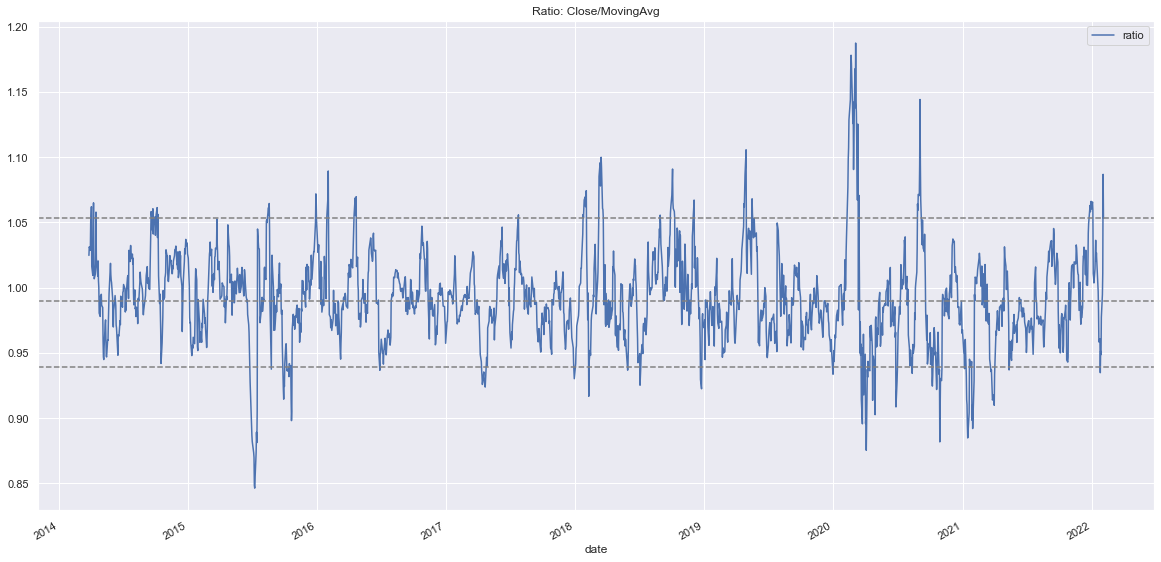

In [9]:
data['ratio'].dropna().plot(legend = True)
plt.axhline(p[0],  c = (.5,.5,.5), ls = '--')
plt.axhline(p[2],  c = (.5,.5,.5), ls = '--')
plt.axhline(p[-1], c = (.5,.5,.5), ls = '--')
plt.title('Ratio: Close/MovingAvg');

In [10]:
short = p[-1]
long = p[0]
data['position'] = np.where(data.ratio > short, -1, np.nan) #np.nan = False
data['position'] = np.where(data.ratio < long, 1, data['position'])
data['position'] = data['position'].ffill()

data

,close,returns,moving_avg,ratio,position
date,,,,,
2022-03-04,2642.44,NaN,NaN,NaN,NaN
2022-03-03,2686.16,0.016410,NaN,NaN,NaN
2022-03-02,2695.03,0.003297,NaN,NaN,NaN
2022-03-01,2683.36,-0.004340,NaN,NaN,NaN
2022-02-28,2697.82,0.005374,NaN,NaN,NaN
...,...,...,...,...,...
2014-04-02,567.00,-0.004821,538.323333,1.053270,-1.0
2014-04-01,567.16,0.000282,540.028571,1.050241,-1.0
2014-03-31,556.97,-0.018130,541.471905,1.028622,-1.0


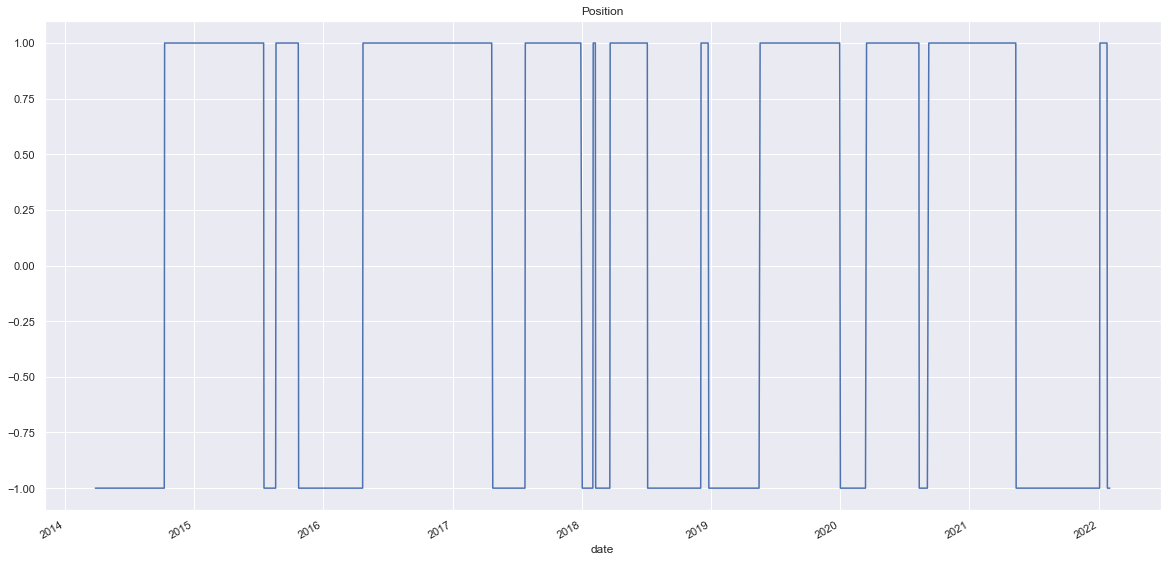

In [11]:
data.position.dropna().plot()
plt.title('Position');

In [12]:
data['strat_return'] = data['returns'] * data['position'].shift()
data.tail()

,close,returns,moving_avg,ratio,position,strat_return
date,,,,,,
2014-04-02,567.00,-0.004821,538.323333,1.053270,-1.0,0.004821
2014-04-01,567.16,0.000282,540.028571,1.050241,-1.0,-0.000282
2014-03-31,556.97,-0.018130,541.471905,1.028622,-1.0,0.018130
2014-03-28,559.99,0.005408,543.009524,1.031271,-1.0,-0.005408
2014-03-27,558.46,-0.002736,544.976667,1.024741,-1.0,0.002736


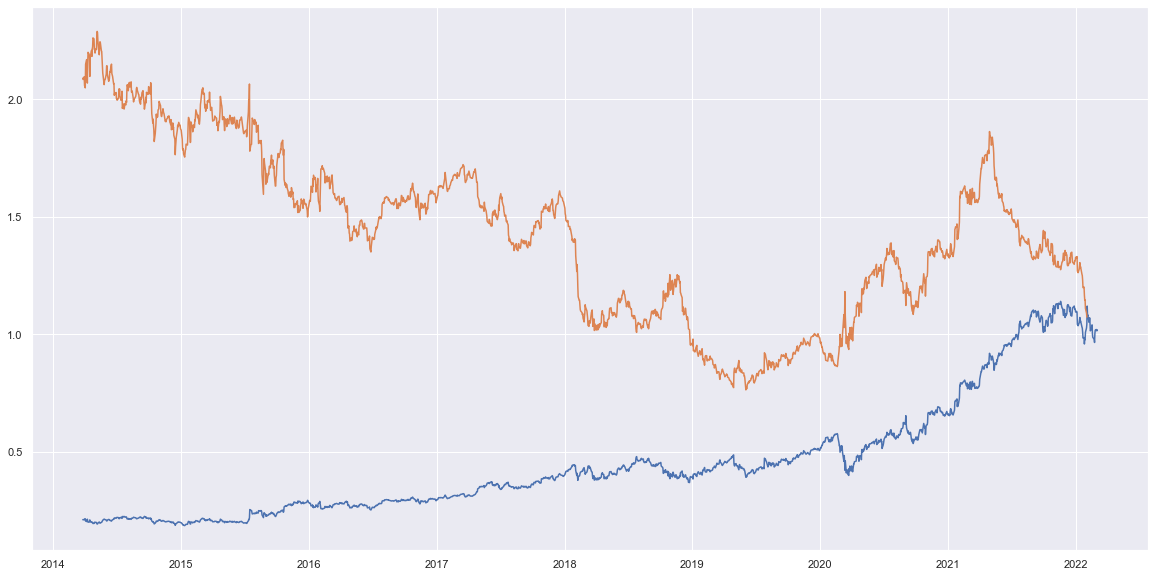

In [13]:
plt.plot(np.exp(data['returns'].dropna()).cumprod(), label = 'Buy/Hold')
plt.plot(np.exp(data['strat_return'].dropna()).cumprod(), label = 'Strategy');

In [14]:
print(np.exp(data['returns'].dropna()).cumprod()[-1]-1)
print(np.exp(data['strat_return'].dropna()).cumprod()[-1]-1)

-0.7886574529601428
1.0906376287923947
